# Load data

In [1]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# df = pd.read_excel('ИсходныеДанные.xlsx')
# df.to_csv('ИсходныеДанные.csv', index = None, header=True)

In [3]:
# Define a custom date parsing function
def parse_datetime(date_string):
    return pd.to_datetime(date_string, format='%d.%m.%Y %H:%M:%S')

In [4]:
%%time
df = pd.read_csv('ИсходныеДанные.csv', parse_dates=['ДатаЗаказа', 'ДатаПоследнегоСтатуса'], date_parser=parse_datetime)

<timed exec>:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 4.53 s
Wall time: 5.05 s


In [5]:
df

,id,Номер,ДатаЗаказа,Статус,ПопыткиДоставки,ДатаПоследнегоСтатуса,СуммаДокумента,Подразделение,landing_id,calls_count,is_external,subpartner_id,source_id,gender_id,age,offer_id
0,26979616,DL00-041395,2022-01-11 16:39:44,Не выкуплен,2.0,2022-01-21 15:02:25,4095.0,Челябинск,3 247,7.0,1.0,198857,139,2.0,51.0,NaN
1,27019247,DL00-041396,2022-01-11 16:40:14,Не выкуплен,1.0,2022-01-28 15:57:44,8524.0,Челябинск,3 322,7.0,1.0,108259,142,1.0,52.0,NaN
2,27021940,DL00-040951,2022-01-10 19:33:08,Выкуплен,1.0,2022-01-11 22:34:27,4500.0,Нальчик,3 179,1.0,NaN,NaN,NaN,2.0,65.0,1932.0
3,27110077,DL00-040961,2022-01-10 19:38:01,Выкуплен,2.0,2022-01-17 16:51:38,8524.0,Сочи,3 054,2.0,1.0,156616,139,2.0,67.0,NaN
4,26987386,DL00-040964,2022-01-10 20:27:12,Выкуплен,1.0,2022-01-12 21:58:41,4238.0,Махачкала,3 336,6.0,NaN,NaN,NaN,1.0,80.0,2110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336189,5981410,DL00-372465,2023-08-24 12:21:17,Отказ,1.0,2023-08-26 04:38:59,7900.0,Барнаул,3 770,1.0,1.0,8294.0,59601.0,2.0,55.0,2462.0
336190,5993889,DL00-372466,2023-08-24 12:21:18,Не выкуплен,1.0,2023-08-25 05:56:06,7900.0,Кемерово,3 770,1.0,1.0,8294.0,59601.0,1.0,52.0,2462.0
336191,5983076,DL00-372469,2023-08-24 12:22:00,Выкуплен,1.0,2023-08-27 06:01:14,3901.0,Новосибирск,3 736,5.0,1.0,9368.0,63065.0,1.0,56.0,2588.0
336192,6017981,DL00-372473,2023-08-24 12:22:05,Выкуплен,1.0,2023-08-27 06:05:13,1040.0,Новосибирск,3 878,NaN,NaN,NaN,NaN,2.0,65.0,2590.0


# Prepare data

In [6]:
# Delete NaN
age_mean = df['age'].mean()
df = df.dropna(thresh=13)
df = df.fillna(value={'landing_id':0,'calls_count':0,'is_external':0,'subpartner_id':0, 
                      'source_id':0, 'offer_id':0, 'gender_id':1.5, 'age': age_mean})

In [7]:
df['landing_id'] = df['landing_id'].str.replace(' ','')
df['landing_id'] = pd.to_numeric(df['landing_id'], errors='coerce').fillna(0).astype('float64')
df['subpartner_id'] = pd.to_numeric(df['subpartner_id'], errors='coerce').fillna(0).astype('float64')
df['source_id'] = pd.to_numeric(df['source_id'], errors='coerce').fillna(0).astype('float64')

In [8]:
df = df.dropna()

In [9]:
# add delivery days
df['DaysDelivery'] = (df['ДатаПоследнегоСтатуса'] - df['ДатаЗаказа']).dt.days

# cut 15 days from data
df = df[df['ДатаЗаказа'] < (df.ДатаЗаказа.max() - pd.DateOffset(days=15))]

# leave only delivered less than 60 days and less 7 trying
df = df[(df['DaysDelivery'] <= 60) & (df['ПопыткиДоставки'] <= 7)]

# Covert departments to codes
df['Department'] = df['Подразделение'].astype('category').cat.codes
department_codes = dict(zip(df['Подразделение'], df['Department']))
# df['Department'] = LabelEncoder().fit_transform(df['Подразделение'])

# add redeemed
df['Redeemed'] = df['Статус'].apply(lambda x: 1 if x == 'Выкуплен' else 0)

# del document number
# df = df.drop(columns=['Номер'])

df['Weekday'] = df['ДатаПоследнегоСтатуса'].dt.weekday

df

,id,Номер,ДатаЗаказа,Статус,ПопыткиДоставки,ДатаПоследнегоСтатуса,СуммаДокумента,Подразделение,landing_id,calls_count,is_external,subpartner_id,source_id,gender_id,age,offer_id,DaysDelivery,Department,Redeemed,Weekday
0,26979616,DL00-041395,2022-01-11 16:39:44,Не выкуплен,2.0,2022-01-21 15:02:25,4095.0,Челябинск,3247.0,7.0,1.0,198857.0,139.0,2.0,51.0,0.0,9,53,0,4
1,27019247,DL00-041396,2022-01-11 16:40:14,Не выкуплен,1.0,2022-01-28 15:57:44,8524.0,Челябинск,3322.0,7.0,1.0,108259.0,142.0,1.0,52.0,0.0,16,53,0,4
2,27021940,DL00-040951,2022-01-10 19:33:08,Выкуплен,1.0,2022-01-11 22:34:27,4500.0,Нальчик,3179.0,1.0,0.0,0.0,0.0,2.0,65.0,1932.0,1,27,1,1
3,27110077,DL00-040961,2022-01-10 19:38:01,Выкуплен,2.0,2022-01-17 16:51:38,8524.0,Сочи,3054.0,2.0,1.0,156616.0,139.0,2.0,67.0,0.0,6,42,1,0
4,26987386,DL00-040964,2022-01-10 20:27:12,Выкуплен,1.0,2022-01-12 21:58:41,4238.0,Махачкала,3336.0,6.0,0.0,0.0,0.0,1.0,80.0,2110.0,2,24,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335936,5838011,DL00-365993,2023-08-09 12:17:35,Выкуплен,1.0,2023-08-10 14:12:51,8586.0,Кемерово,3917.0,1.0,1.0,8294.0,60849.0,1.0,57.0,2656.0,1,16,1,3
335938,5835944,DL00-366005,2023-08-09 12:17:49,Выкуплен,1.0,2023-08-10 14:12:53,7900.0,Кемерово,3770.0,1.0,1.0,8294.0,59601.0,2.0,64.0,2462.0,1,16,1,3
335939,5875571,DL00-366008,2023-08-09 12:18:35,Выкуплен,1.0,2023-08-10 15:49:41,4400.0,Красноярск,3717.0,1.0,1.0,604.0,60312.0,2.0,73.0,1823.0,1,19,1,3
335940,5884512,DL00-366009,2023-08-09 12:18:36,Не выкуплен,1.0,2023-08-10 15:54:52,7286.0,Красноярск,3917.0,14.0,1.0,8294.0,60849.0,1.0,65.0,2656.0,1,19,0,3


In [10]:
df = df.rename(columns={"ПопыткиДоставки": "DeliveryAttempt", "СуммаДокумента": "OrderAmount"})

# Some interesting information

### Процент успешных доставок по количеству попыток доставки

<AxesSubplot: xlabel='DeliveryAttempt'>

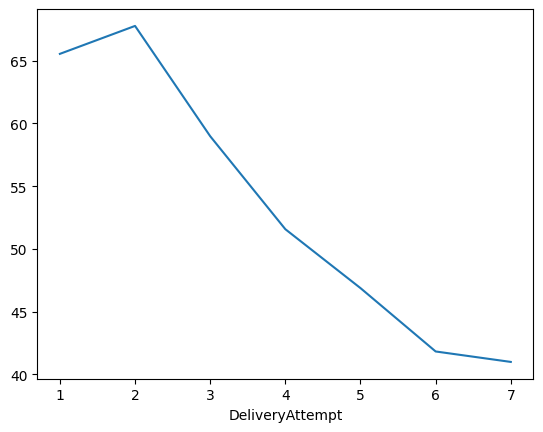

In [11]:
success_percentage = df.groupby('DeliveryAttempt')['Redeemed'].mean()*100
success_percentage.plot()

### Процент успешных доставок по количеству дней доставки

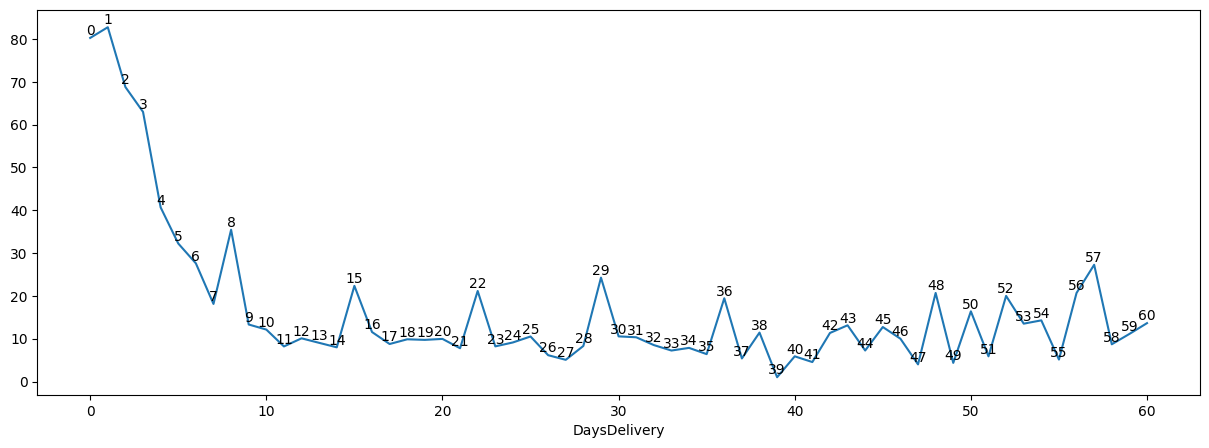

In [12]:
success_percentage = df.groupby('DaysDelivery')['Redeemed'].mean()*100
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(success_percentage)
    
ax = success_percentage.plot(figsize=(15,5))
# Add text annotations for each value
for i, value in enumerate(success_percentage):
    ax.text(i, value, f'{i}', ha='center', va='bottom')

### Распределение по возрастам

<AxesSubplot: >

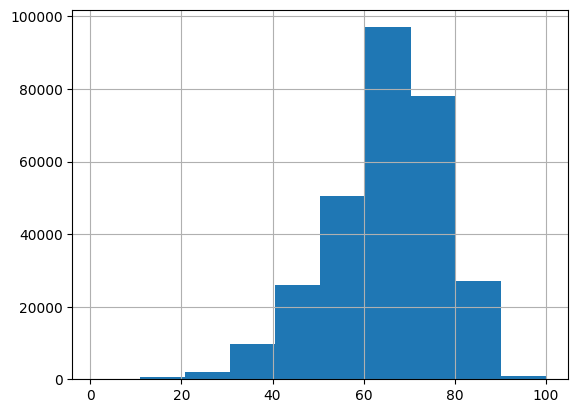

In [13]:
df['age'].hist()

<AxesSubplot: xlabel='ДатаЗаказа', ylabel='calls_count'>

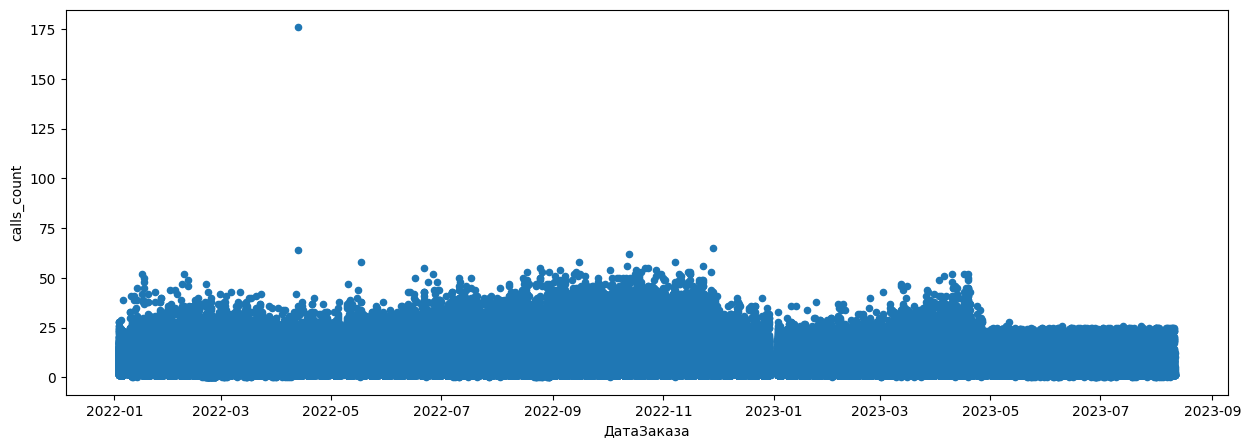

In [14]:
df.plot(kind='scatter', y='calls_count', x='ДатаЗаказа', figsize=(15,5))

C:\Users\NovPa\AppData\Local\Temp\ipykernel_28372\3874070677.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ДатаЗаказа'] = df1['ДатаЗаказа'].dt.to_period('M')


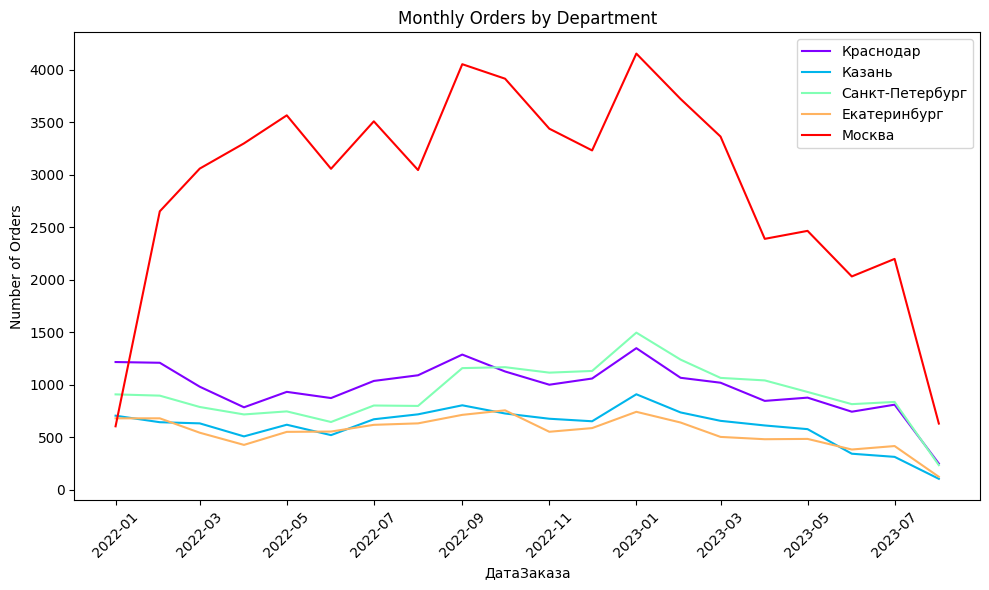

In [15]:
df1 = df[['ДатаЗаказа', 'Подразделение']]
df1['ДатаЗаказа'] = df1['ДатаЗаказа'].dt.to_period('M')
top_departments = df1.groupby(['Подразделение']).size().reset_index(name='order_count').sort_values(by=['order_count'], ascending=False).head(5)
df1 = df1.merge(top_departments)
department_monthly_counts = df1.groupby(['Подразделение', 'ДатаЗаказа']).size().reset_index(name='order_count')

plt.figure(figsize=(10, 6))

departments = df1['Подразделение'].unique()
colors = plt.cm.rainbow([i/float(len(departments)-1) for i in range(len(departments))])

for i, department in enumerate(departments):
    department_data = department_monthly_counts[department_monthly_counts['Подразделение'] == department]
    plt.plot(department_data['ДатаЗаказа'].dt.to_timestamp(), department_data['order_count'], color=colors[i], label=department)

plt.xlabel('ДатаЗаказа')
plt.ylabel('Number of Orders')
plt.title('Monthly Orders by Department')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Decision tree

In [16]:
X = df[['DeliveryAttempt', 'DaysDelivery', 'Department', 'OrderAmount', 'Weekday', 'landing_id',
        'calls_count', 'is_external', 'subpartner_id', 'source_id', 'gender_id', 'age', 'offer_id']]
y = df.Redeemed

In [17]:
clf = tree.DecisionTreeClassifier()
clf

DecisionTreeClassifier()

In [18]:
parameters = {'criterion':['gini', 'entropy'], 'max_depth': range(1,20)}

In [19]:
grid_search_cv_slf = GridSearchCV(clf, parameters, cv=5)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

In [21]:
grid_search_cv_slf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20)})

In [22]:
grid_search_cv_slf.best_params_

{'criterion': 'entropy', 'max_depth': 10}

In [23]:
best_clf = grid_search_cv_slf.best_estimator_

In [24]:
best_clf.score(X_test, y_test)

0.8307370210296114

CPU times: total: 1.92 s
Wall time: 2.18 s


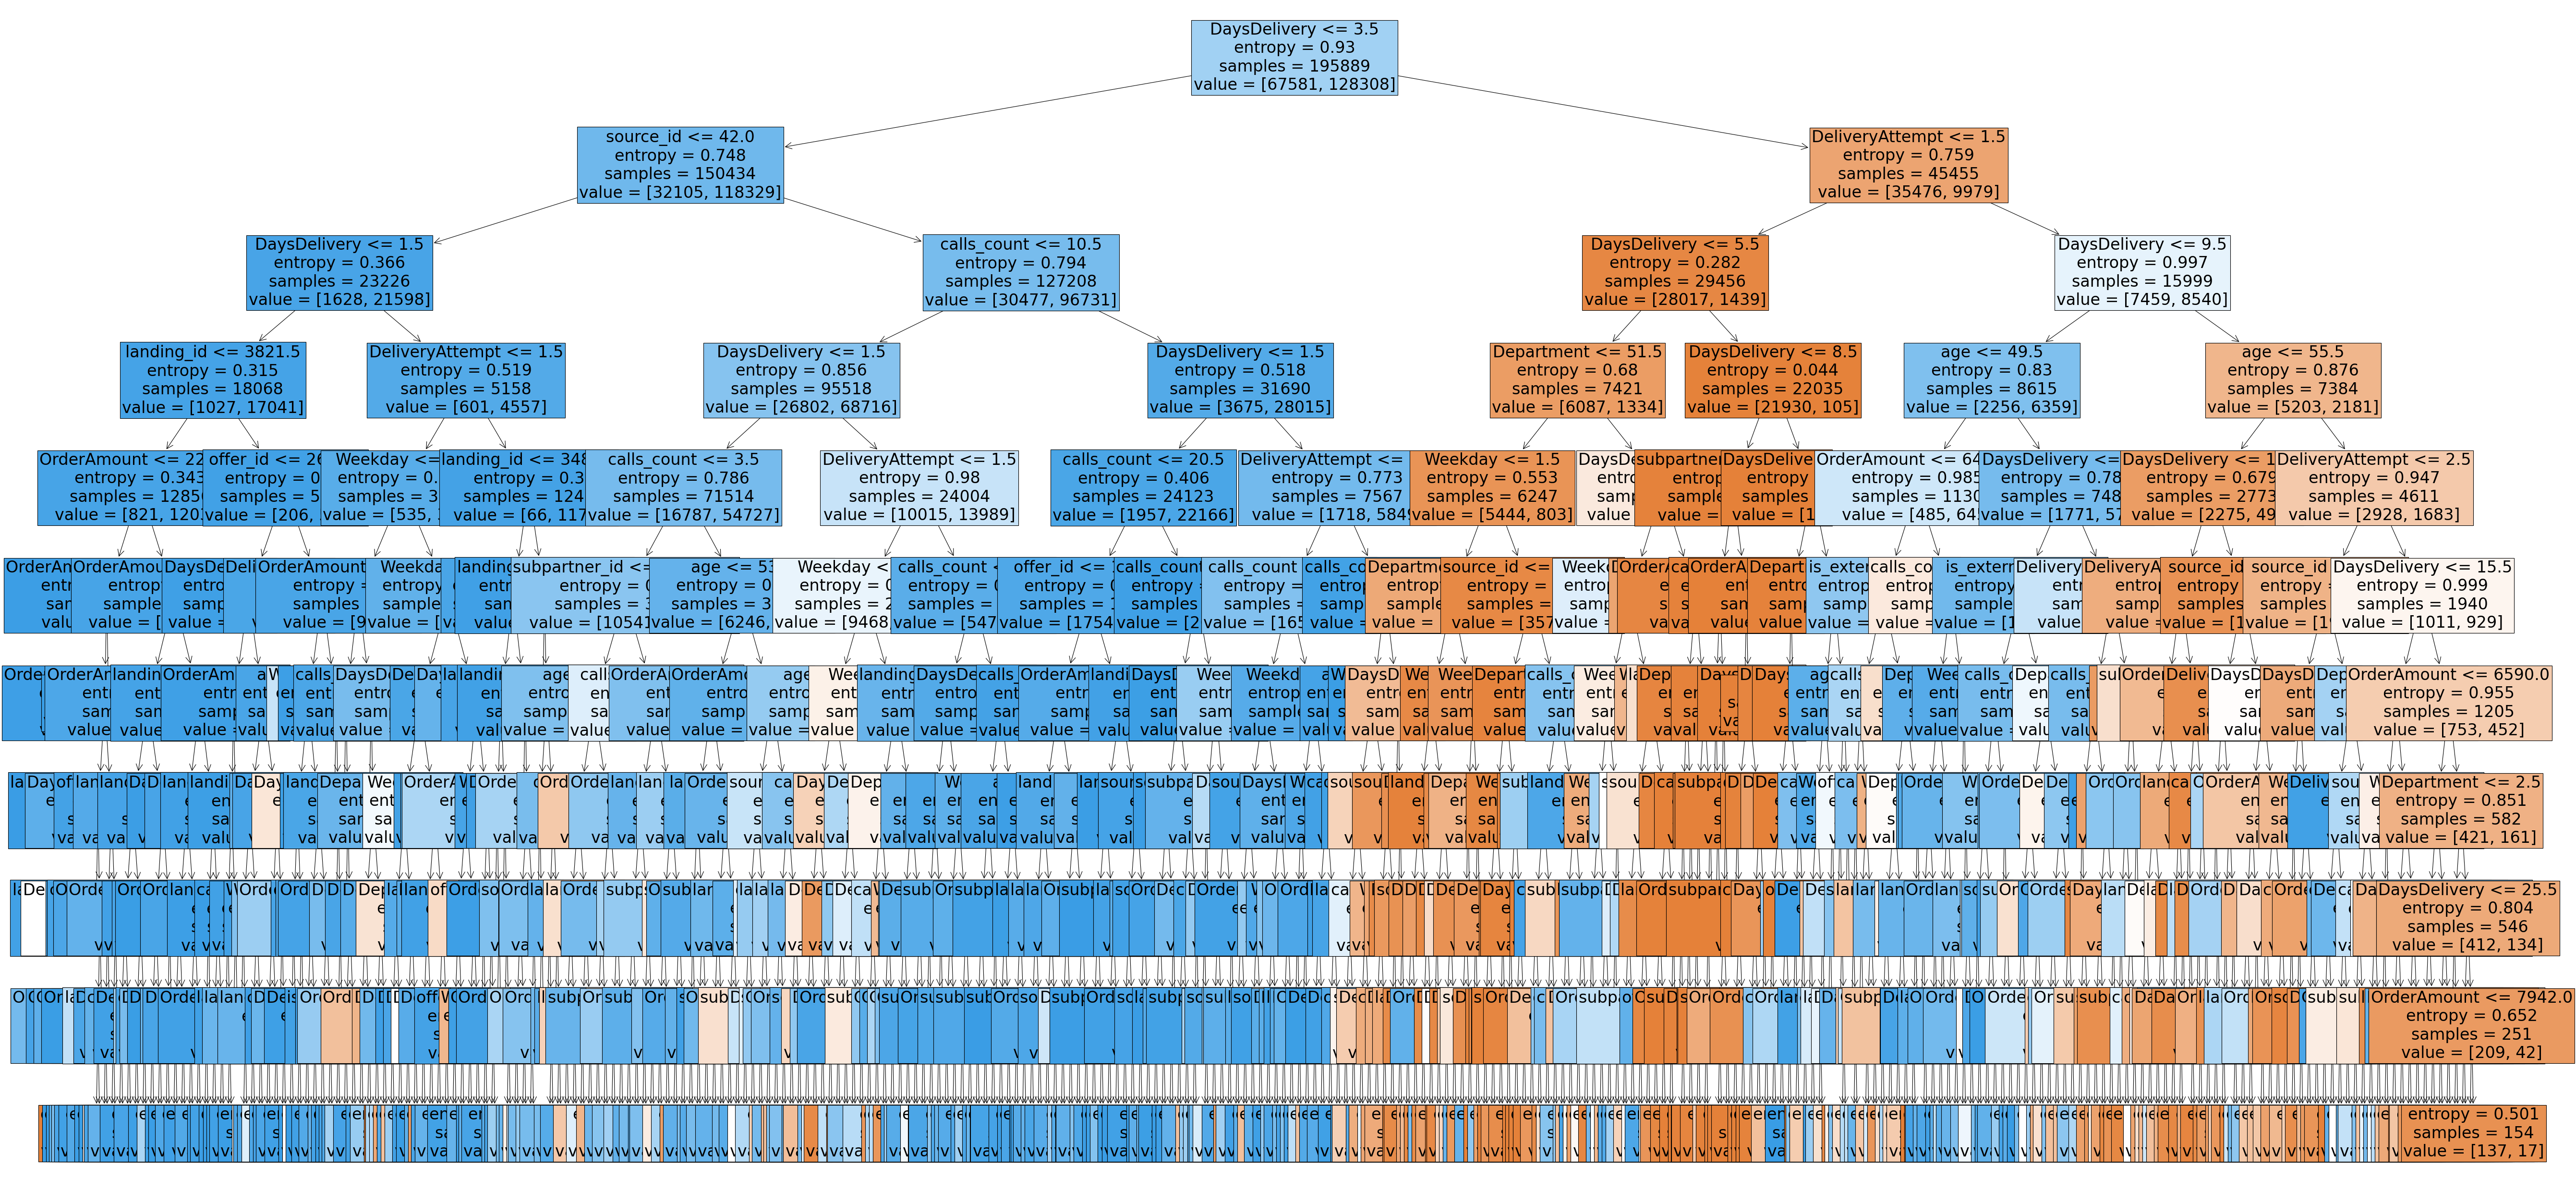

In [35]:
%%time
plt.figure(figsize=(80, 40),dpi=80)
p = tree.plot_tree(best_clf, fontsize=30, filled=True,feature_names=list(X_test))

In [25]:
report = classification_report(y_test, best_clf.predict(X_test), target_names=['Non-redeemed', 'redeemed'])
print(report)

              precision    recall  f1-score   support

Non-redeemed       0.87      0.60      0.71     33286
    redeemed       0.82      0.95      0.88     63197

    accuracy                           0.83     96483
   macro avg       0.84      0.78      0.80     96483
weighted avg       0.84      0.83      0.82     96483



# Feature importance

In [26]:
feature_importance = best_clf.feature_importances_
feature_importance

array([1.58287307e-01, 5.79658871e-01, 3.70457153e-02, 1.77807663e-02,
       3.95802764e-02, 1.13169287e-02, 7.27948270e-02, 1.25656105e-03,
       1.12772018e-02, 4.69433992e-02, 1.08217704e-04, 1.75776679e-02,
       6.37226137e-03])

In [27]:
imp = pd.DataFrame(feature_importance, index=X_train.columns, columns=['importance'])
imp.sort_values('importance', ascending=False)

,importance
DaysDelivery,0.579659
DeliveryAttempt,0.158287
calls_count,0.072795
source_id,0.046943
Weekday,0.039580
Department,0.037046
OrderAmount,0.017781
age,0.017578
landing_id,0.011317
subpartner_id,0.011277


<AxesSubplot: >

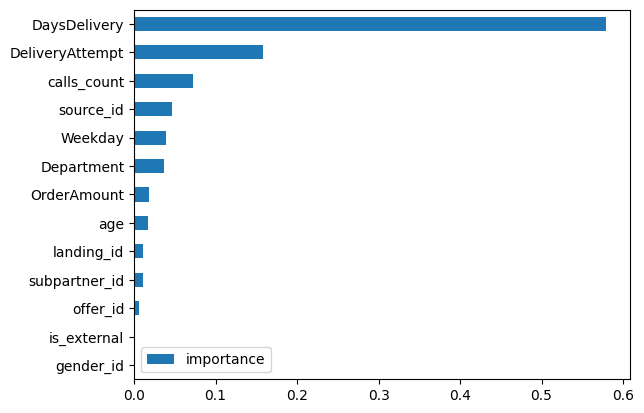

In [28]:
imp.sort_values('importance').plot(kind='barh', )

# roc_curve

In [29]:
y_pred_prob = best_clf.predict_proba(X_test)
y_pred_prob

array([[0.1904    , 0.8096    ],
       [0.35294118, 0.64705882],
       [0.08280255, 0.91719745],
       ...,
       [0.48275862, 0.51724138],
       [0.20967742, 0.79032258],
       [0.06870381, 0.93129619]])

<AxesSubplot: >

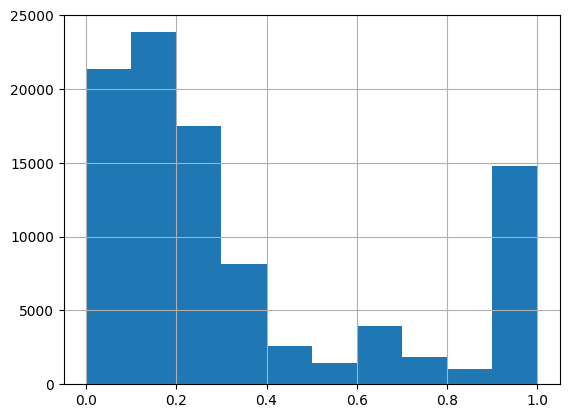

In [30]:
# Гистрограмма что не будут доставлены
pd.Series(y_pred_prob[:, 0]).hist()

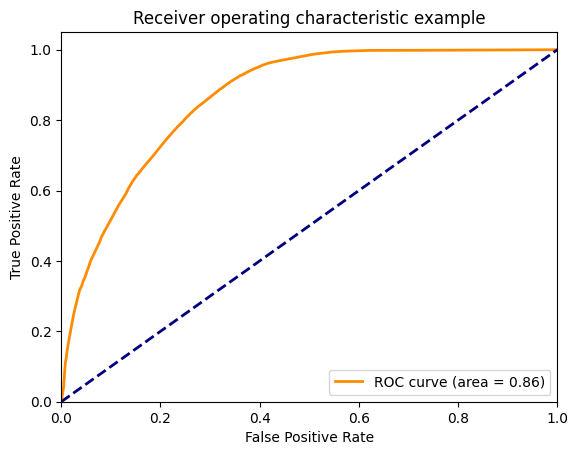

In [31]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
lw = 2
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Save model and departments

In [33]:
# import pickle
# pickle.dump(best_clf, open('clf_model.sav', 'wb'))
# with open('department_codes.json', 'w') as f:
#     json.dump(department_codes, f)